# Summary

A common task in finance is forecasting values. There are several methods for creating forecasts such as ARIMA, Bayesian Structural Time Series, and simulation. Monte Carlo is a simulation technique based on generating random walks over a period of time. 

# Tutorial Overview
In this module, we will:
1. Import Henry Hub Natural Gas prices
2. Simulate future price movements using Monte Carlo 
3. Plot the simulated future paths


In [1]:
#Import Libraries
import sys
try:
    import pandas_datareader as web
except: 
    !conda install --yes --prefix {sys.prefix} pandas-datareader
import numpy as np  
np.random.seed(3363)
import pandas as pd  
import pandas_datareader as web  
from scipy.stats import norm
import datetime 

import matplotlib.pyplot as plt
%matplotlib inline

from config.quandl_config import QUANDL_API_KEY as api_key# file with my personal Quandl Key

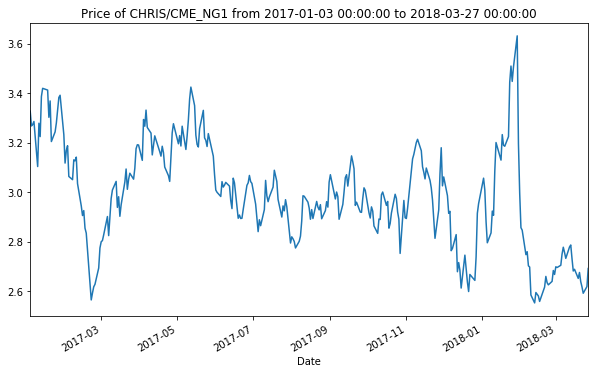

In [2]:
# Settings for Monte Carlo asset data, how long, and how many forecasts 
ticker = 'CHRIS/CME_NG1' # Natural Gas (Henry Hub) Physical Futures, Continuous Contract #1 (NG1) (Front Month)
t_intervals = 30 # time steps forecasted into future
iterations = 25 # amount of simulations

start_date = datetime.datetime(2017, 1, 3)
end_date = datetime.datetime(2018, 3, 27)
pred_end_date = datetime.datetime(2019, 10, 3)

df = web.DataReader(ticker, 'quandl', start_date, end_date, api_key = api_key)['Settle'] # Some tickers use 'Close' instead of 'Settle'

#Plot of asset historical closing price
df.plot(figsize=(10, 6), title = "Price of {} from {} to {}".format(ticker, start_date, end_date))

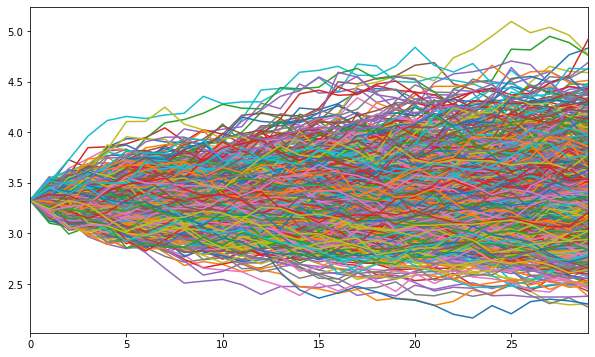

In [3]:
forecast_dates = [d if d.isoweekday() in range(1, 6) else np.nan for d in pd.date_range(end_date, pred_end_date)] 
intervals = len(forecast_dates)
iterations = 1000
#Preparing log returns from data
log_returns = np.log(1 + df.pct_change())

#Setting up drift and random component in relation to asset data
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5 * var)
stdev = log_returns.std()
daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))

#Takes last data point as startpoint point for simulation
S0 = df.iloc[-1]
price_list = np.zeros_like(daily_returns)
price_list[0] = S0
#Applies Monte Carlo simulation in asset
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]

forecast_df = pd.DataFrame(price_list)
    

forecast_df.plot(figsize=(10,6), legend=False)


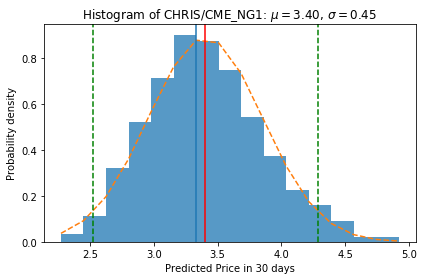

In [9]:
# Plotting with a histogram

x = forecast_df.values[-1]
sigma = np.std(x)
mu = np.mean(x)

num_bins = 15

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1, alpha=.75)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.axvline(np.mean(x), color='r')
ax.axvline(mu+sigma*1.96, color='g', ls='--')
ax.axvline(mu-sigma*1.96, color='g', ls='--')
ax.axvline(S0)
ax.set_xlabel('Predicted Price in 30 days')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of {ticker}: $\mu={mu:.02f}$, $\sigma={sigma:.02f}$'.format(ticker = ticker, mu=mu, sigma=sigma))

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()